###**Import Libraries**

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

###**Fitness Function**

In [2]:
# Common fitness function for GA and PSO

df = pd.read_csv('/Users/saifhaddad/Downloads/WSNBFSFdataset V2.csv')


rate_of_energy_consumption = df['rate_of_energy_consumption']
ttl = df['TTL']
hop_count = df['Hop_Count']


def fitness_function(ind):
    w1,w2,w3=ind
    
    
    if (w1+w2+w3 > 1):
        return 99999991
    
    
    
    
    df['risk_score'] = w1 * rate_of_energy_consumption + w2 * ttl + w3 * hop_count

    if any(df['risk_score']>100):
        return 999999993
    
    if df['risk_score'].sum() < 50:
        return 999999994

    
    return df['risk_score'].min()




###**Genetic Algorithm**

In [3]:
#Creates a random individual
def individual(ind_size, ind_limits):
    ind = []
    for i in range(ind_size):
        ind.append(random.uniform(ind_limits[i][0], ind_limits[i][1]))
    return ind

In [4]:
#Performs crossover between two parents
def crossover(parent1, parent2):
    if len(parent1) == 1:
        return parent1  # Or you could do some other type of mixing, but with 1 element it's a moot point
    point = random.randint(1, len(parent1) - 1)
    child = parent1[:point] + parent2[point:]
    return child

In [5]:
#Mutates the child
def mutate(child, ind_limits):
    index = random.randint(0, len(child) - 1)
    child[index] = random.uniform(ind_limits[index][0], ind_limits[index][1])
    return child

In [6]:
#Select two parents based on fitness
def select_parents(population, fit_func):
    k = 2
    parent1 = population[0]
    parent2 = max(random.choices(population, k=k), key=fit_func)
    return parent1, parent2

In [7]:



def genetic_algorithm(ind_size, ind_limits, fit_func, pop_size, gen_max):
    population = []
    best_fitnesses = []  # This list will store the best fitness in each generation
    for i in range(pop_size):
        population.append(individual(ind_size, ind_limits))
    for gen in range(gen_max):
        population.sort(key=fit_func)
        best_fitness = fit_func(population[0])  # Take the best individual's fitness
        best_fitnesses.append(best_fitness)  # Add the best fitness to the list
        parent1, parent2 = select_parents(population, fit_func)

        child = crossover(parent1, parent2)
        child = mutate(child, ind_limits)

        # Replace the least fit individual
        population[-1] = child

    # Printing the best individual results for the final results
    best_individual = population[0]



    return best_individual, best_fitnesses

###**Particle Swarm Optimization**

In [8]:
# Initialize a random particle
def particle(ind_size, ind_limits):
    ind = []
    for i in range(ind_size):
        ind.append(random.uniform(ind_limits[i][0], ind_limits[i][1]))
    return ind

In [9]:
# Update velocity
def update_velocity(velocity, pBest_position, gBest_position, particle_position, w, c1, c2):
    new_velocity = []
    for i in range(len(velocity)):
        r1, r2 = random.random(), random.random()
        v = w * velocity[i] + c1 * r1 * (pBest_position[i] - particle_position[i]) + c2 * r2 * (gBest_position[i] - particle_position[i])
        new_velocity.append(v)
    return new_velocity

In [10]:
# Update position
def update_position(particle_position, velocity):
    new_position = []
    for i in range(len(particle_position)):
        pos = particle_position[i] + velocity[i]
        # Ensure positions are within limits
        pos = max(0, min(1, pos))
        new_position.append(pos)
    return new_position

In [11]:
# PSO algorithm
def particle_swarm_optimization(ind_size, ind_limits, fit_func, num_particles, num_iterations):
    w, c1, c2 = 0.1, 0.5, 0.5

    particles = [particle(ind_size, ind_limits) for _ in range(num_particles)]
    velocities = [[random.uniform(-1, 1) for _ in range(ind_size)] for _ in range(num_particles)]

    pBests = particles[:]
    gBest = min(pBests, key=fit_func)
    best_fitnesses = []

    for _ in range(num_iterations):
        for i in range(num_particles):
            # Update personal best
            if fit_func(particles[i]) < fit_func(pBests[i]):
                pBests[i] = particles[i]

            # Update global best
            if fit_func(particles[i]) < fit_func(gBest):
                gBest = particles[i]

            velocities[i] = update_velocity(velocities[i], pBests[i], gBest, particles[i], w, c1, c2)
            particles[i] = update_position(particles[i], velocities[i])

        best_fitness = fit_func(gBest)
        best_fitnesses.append(best_fitness)

    return gBest, best_fitnesses

###**Running Algorithms and Plotting**

In [12]:
def run_algorithms_and_plot(NUM_RUNS, IND_LIMITS, IND_SIZE, pop_size, gen_max, num_particles, num_iterations):
    # Data collection for line chart
    line_data_GA = []
    line_data_PSO = []
    best_fitnesses_all_iterations_GA = []
    best_fitnesses_all_iterations_PSO = []

    best_solution_GA = None
    best_fitness_GA = float('inf')
    best_run_GA = None
    best_gen_GA = None

    best_solution_PSO = None
    best_fitness_PSO = float('inf')
    best_run_PSO = None
    best_iter_PSO = None

    print("Starting GA runs...")
    # Run GA NUM_RUNS times
    for i in range(NUM_RUNS):
        print("\rRunning GA iteration", i+1,NUM_RUNS, end='')
        best_solution, fitness_over_time = genetic_algorithm(IND_SIZE, IND_LIMITS, fitness_function, pop_size, gen_max)
        line_data_GA.append(fitness_over_time)
        best_fitnesses_all_iterations_GA.append(fitness_function(best_solution))
        if fitness_function(best_solution) < best_fitness_GA:
          best_fitness_GA = fitness_function(best_solution)
          best_solution_GA = best_solution
          best_run_GA = i
          best_gen_GA = np.argmin(fitness_over_time)
    print("\nGA runs completed.")
    # Average the fitness over all runs for GA
    avg_line_data_GA = np.mean(line_data_GA, axis=0)
    print("\n\nStarting PSO runs...")
    # Run PSO NUM_RUNS times
    for i in range(NUM_RUNS):
        print("\rRunning PSO iteration", i+1,NUM_RUNS, end='')
        best_particle, fitness_over_time = particle_swarm_optimization(IND_SIZE, IND_LIMITS, fitness_function, num_particles, num_iterations)
        best_fitnesses_all_iterations_PSO.append(fitness_function(best_particle))
        line_data_PSO.append(fitness_over_time)
        if fitness_function(best_particle) < best_fitness_PSO:
           best_fitness_PSO = fitness_function(best_particle)
           best_solution_PSO = best_particle
           best_run_PSO = i
           best_iter_PSO = np.argmin(fitness_over_time)

    print("\nPSO runs completed.\n\n")
    # Average the fitness over all runs for PSO
    avg_line_data_PSO = np.mean(line_data_PSO, axis=0)

# Plotting
    fig1, ax1 = plt.subplots(figsize=(15, 7))
# Line chart for GA and PSO
    plt.plot(avg_line_data_GA, label="GA")
    plt.plot(avg_line_data_PSO, label="PSO")
    plt.title('Generation/Iteration vs. Average Fitness')
    plt.xlabel('Generation/Iteration')
    plt.ylabel('Average Fitness Value')
    plt.legend()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(15, 7)) # you can adjust this size
    box = plt.boxplot([best_fitnesses_all_iterations_GA, best_fitnesses_all_iterations_PSO],
                  labels=['GA', 'PSO'], patch_artist=True, widths=0.3)
    colors = ['cyan', 'pink']
    for patch, color in zip(box['boxes'], colors):
      patch.set_facecolor(color)
    #plt.xlim(0.3, 2.7)
    plt.gca().set_position([0.1, 0.1, 0.8, 0.8])
    plt.title('Boxplot of Best Fitnesses for Each Iteration')
    plt.ylabel('Fitness Value')
    plt.subplots_adjust(wspace=0.7)  # Adjust the spacing between subplots
    plt.tight_layout()
    plt.show()


    print("GA: Best solution is",best_solution_GA, "with fitness ",best_fitness_GA,"Found at run", best_run_GA + 1, "and generation ",best_gen_GA + 1)
    print("PSO: Best solution is", best_solution_PSO, "with fitness", best_fitness_PSO, "Found at run",best_run_PSO + 1, "and iteration",best_iter_PSO + 1)


###**Setting the algorithm parameters**

Starting GA runs...
Running GA iteration 10 10
GA runs completed.


Starting PSO runs...
Running PSO iteration 10 10
PSO runs completed.




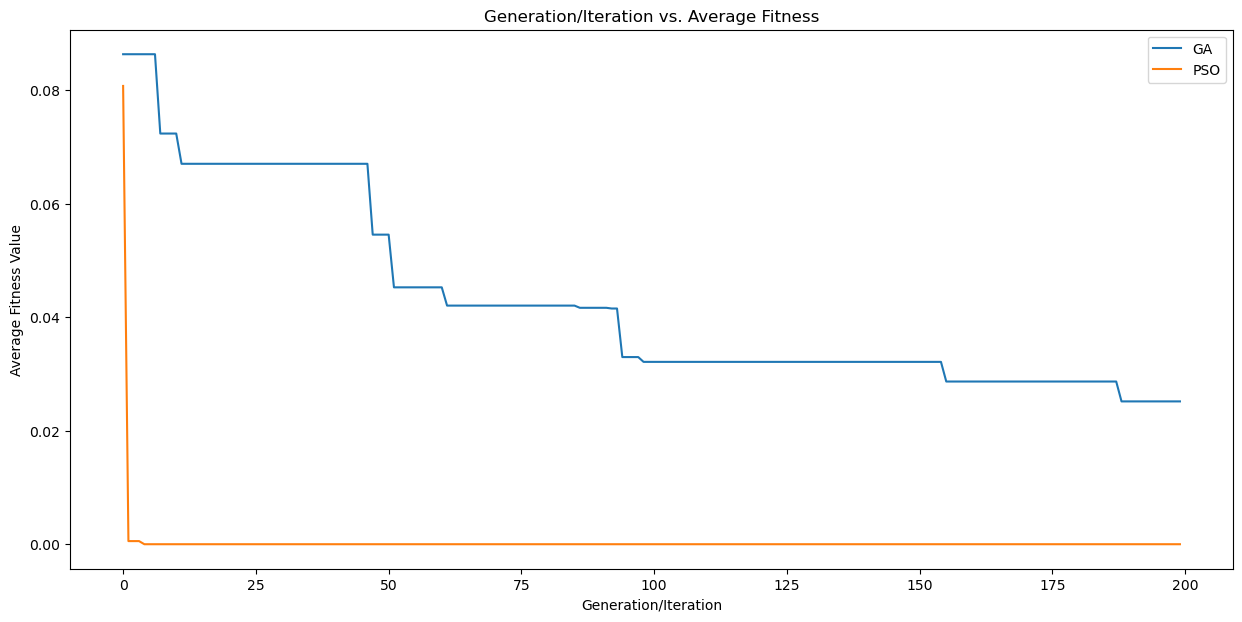

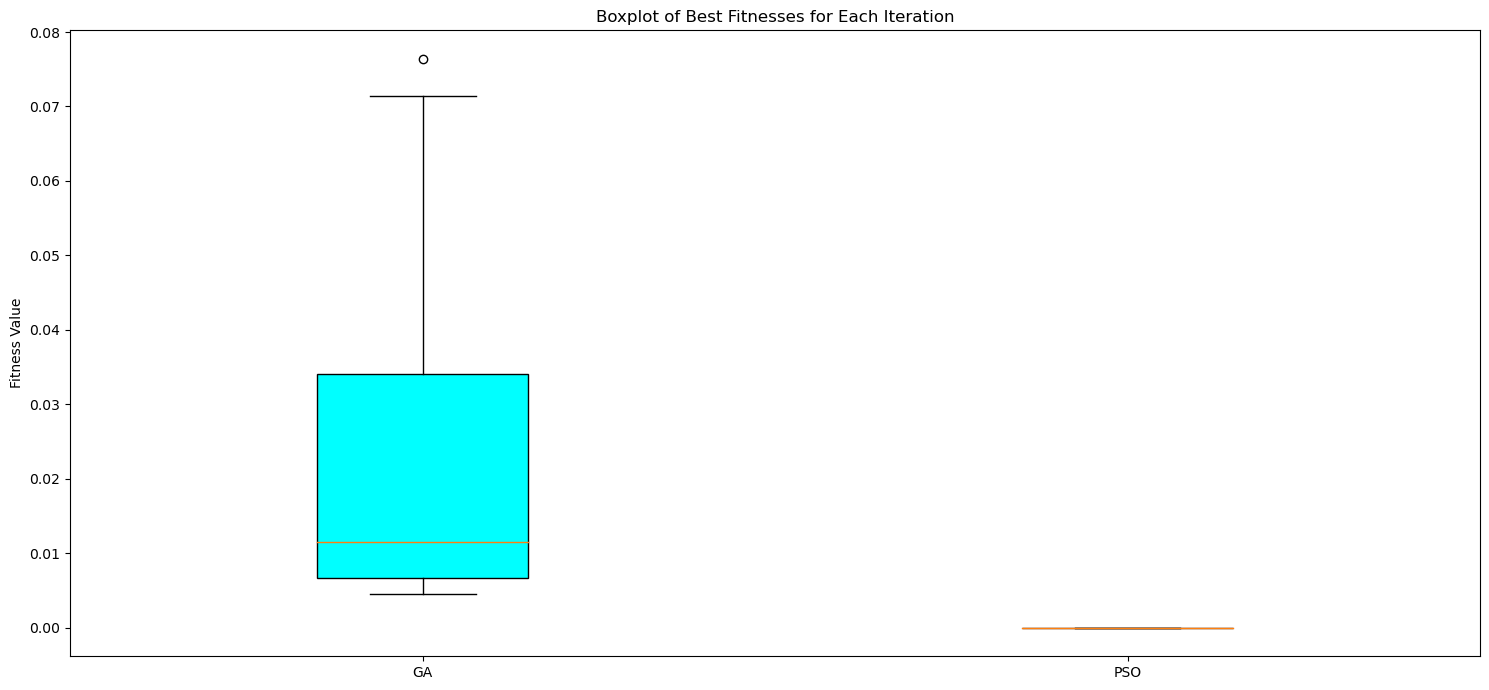

GA: Best solution is [0.3199059045865893, 0.668997243828676, 0.0009042492845308114] with fitness  0.004521246422654057 Found at run 10 and generation  93
PSO: Best solution is [0.3696740251976166, 0.4299038744018192, 0] with fitness 0.0 Found at run 1 and iteration 2


In [13]:
# Setting the algorithm parameters
NUM_RUNS = 10

IND_LIMITS = [(0, 1), (0, 1),(0,1)]
IND_SIZE = 3

pop_size = 100
num_particles = 100

gen_max = 200
num_iterations = 200




# Running the algorithms and plotting
run_algorithms_and_plot(NUM_RUNS, IND_LIMITS, IND_SIZE, pop_size, gen_max, num_particles, num_iterations)

In [16]:
df['risk_score']=0.3696740251976166 * rate_of_energy_consumption + 0.4299038744018192 * ttl + 0 * hop_count

In [18]:
df['risk_score'].describe()

count    312106.000000
mean          9.953330
std           2.465347
min           0.000000
25%           9.289075
50%          10.424757
75%          11.288734
max          63.404659
Name: risk_score, dtype: float64

In [19]:
df[df['behaviour']=='Under attack']['risk_score'].describe()

count    49255.000000
mean        10.749006
std          1.902836
min          0.000000
25%         10.317693
50%         11.177501
75%         11.715314
max         21.377135
Name: risk_score, dtype: float64

In [36]:
# Filter the DataFrame based on risk score threshold
filtered_df = df[df['risk_score'] <= 21.377135]

# Count the total number of instances in the filtered DataFrame
total_count = filtered_df.shape[0]

# Count the number of instances where behaviour is 'Under attack'
under_attack_count = filtered_df[filtered_df['behaviour'] == 'Under attack'].shape[0]

# Calculate the percentage of 'Under attack' instances
if total_count > 0:
    percentage_under_attack = (under_attack_count / total_count) * 100
    print(f"Percentage of instances with risk score <= 21.377135 that are 'Under attack': {percentage_under_attack:.2f}%")
else:
    print("No instances found with risk score <= 21.377135.")


Percentage of instances with risk score <= 21.377135 that are 'Under attack': 15.78%


In [21]:
df[df['behaviour']=='No attack']['risk_score'].describe()

count    262851.000000
mean          9.804230
std           2.529332
min           0.000000
25%           9.134737
50%          10.391639
75%          11.282043
max          63.404659
Name: risk_score, dtype: float64

In [37]:
# Filter the DataFrame based on risk score threshold
filtered_df = df[df['risk_score'] <= 21.377135]

# Count the total number of instances in the filtered DataFrame
total_count = filtered_df.shape[0]

# Count the number of instances where behaviour is 'No attack'
no_attack_count = filtered_df[filtered_df['behaviour'] == 'No attack'].shape[0]

# Calculate the percentage of 'No attack' instances
if total_count > 0:
    percentage_no_attack = (no_attack_count / total_count) * 100
    print(f"Percentage of instances with risk score <= 21.377135 that are 'No attack': {percentage_no_attack:.2f}%")
else:
    print("No instances found with risk score <= 21.377135.")


Percentage of instances with risk score <= 21.377135 that are 'No attack': 84.22%


In [38]:
# Group by 'risk_score' and 'behaviour' and count the occurrences
grouped_df = df.groupby(['risk_score', 'behaviour']).size().reset_index(name='counts')

# Filter to only include rows where behaviour is 'Under attack'
attack_grouped_df = grouped_df[grouped_df['behaviour'] == 'Under attack']

# Sort by 'counts' in descending order to get the risk score with the most attacks on top
sorted_attack_df = attack_grouped_df.sort_values('counts', ascending=False)

# Get the risk score value with the most attacks
if not sorted_attack_df.empty:
    most_attacks_risk_score = sorted_attack_df.iloc[0]['risk_score']
    print(f"The risk score value with the most attacks is {most_attacks_risk_score}.")
else:
    print("No attacks found in the dataset.")


The risk score value with the most attacks is 11.1775007344473.


In [39]:
# Group by 'risk_score' and 'behaviour' and sum the occurrences
grouped_df = df.groupby(['risk_score', 'behaviour']).size().reset_index(name='counts')

# Filter to only include rows where behaviour is 'Under attack'
attack_grouped_df = grouped_df[grouped_df['behaviour'] == 'Under attack']

# Calculate the sum of counts for attacks
total_attacks = attack_grouped_df['counts'].sum()

print(f"The total number of attacks across all unique risk score values is {total_attacks}.")


The total number of attacks across all unique risk score values is 49255.


7         12.897116
18        12.897116
49        12.540164
75        12.553053
85        12.467212
            ...    
312101    12.973027
312102    12.973027
312103    12.973030
312104    12.973027
312105    12.973028
Name: risk_score, Length: 49255, dtype: float64
count    49255.000000
mean        10.749006
std          1.902836
min          0.000000
25%         10.317693
50%         11.177501
75%         11.715314
max         21.377135
Name: risk_score, dtype: float64


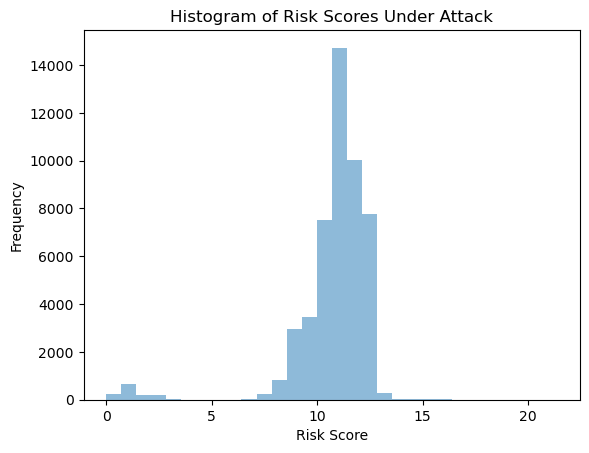

In [22]:
# Filter the dataframe to only include rows where 'behaviour' is 'Under attack'
attack_df = df[df['behaviour'] == 'Under attack']

# Now, `attack_df` contains only the rows where an attack is happening. 
# You can then look at the 'risk_score' column to see the risk scores when under attack.

# To see the risk score values
print(attack_df['risk_score'])

# To get descriptive statistics of the risk_score when under attack
print(attack_df['risk_score'].describe())

# To plot a histogram of the risk scores when under attack
import matplotlib.pyplot as plt
plt.hist(attack_df['risk_score'], bins=30, alpha=0.5, label='Under attack')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.title('Histogram of Risk Scores Under Attack')
plt.show()


In [23]:
# Assuming df is your DataFrame and it has a column named 'behaviour' that indicates whether an attack occurred

# Calculate the mean risk score
mean_risk_score = df['risk_score'].mean()

# Separate the dataset into two subsets
above_mean = df[df['risk_score'] > mean_risk_score]
below_mean = df[df['risk_score'] <= mean_risk_score]

# Count the number of attacks in each subset
attacks_above_mean = above_mean[above_mean['behaviour'] == 'Under attack'].shape[0]
attacks_below_mean = below_mean[below_mean['behaviour'] == 'Under attack'].shape[0]

# Calculate the percentage of attacks for each subset
percentage_attacks_above_mean = (attacks_above_mean / above_mean.shape[0]) * 100
percentage_attacks_below_mean = (attacks_below_mean / below_mean.shape[0]) * 100

print(f"Percentage of attacks when risk score is above the mean: {percentage_attacks_above_mean}%")
print(f"Percentage of attacks when risk score is below the mean: {percentage_attacks_below_mean}%")


Percentage of attacks when risk score is above the mean: 20.484715564118172%
Percentage of attacks when risk score is below the mean: 7.529851997634786%


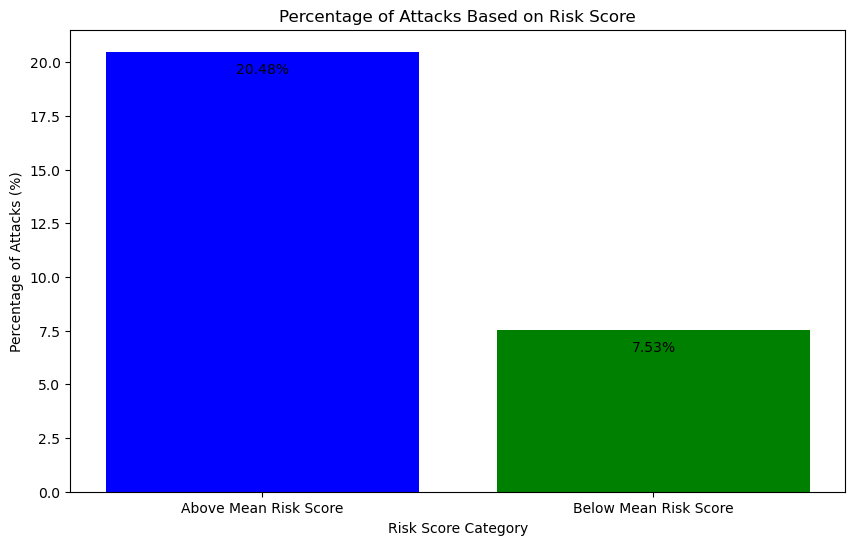

In [24]:
import matplotlib.pyplot as plt

# Assuming mean_risk_score, percentage_attacks_above_mean, and percentage_attacks_below_mean
# are already calculated as shown in the previous code snippet

# Data for plotting
categories = ['Above Mean Risk Score', 'Below Mean Risk Score']
percentages = [percentage_attacks_above_mean, percentage_attacks_below_mean]

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, percentages, color=['blue', 'green'])

# Adding text labels
for i, percentage in enumerate(percentages):
    plt.text(i, percentage - 1, str(round(percentage, 2)) + '%', ha='center')

# Add titles and labels
plt.title('Percentage of Attacks Based on Risk Score')
plt.xlabel('Risk Score Category')
plt.ylabel('Percentage of Attacks (%)')

# Show the plot
plt.show()


In [30]:


df['risk_score_pso'] = 0.3696740251976166 * df['rate_of_energy_consumption'] + 0.4299038744018192 * df['TTL'] + 0 * df['Hop_Count']


under_attack_scores = df[df['behaviour'] == 'Under attack']['risk_score_pso']
no_attack_scores = df[df['behaviour'] == 'No attack']['risk_score_pso']

print("Statistics for 'Under attack':")
print(under_attack_scores.describe())

print("\nStatistics for 'No attack':")
print(no_attack_scores.describe())



threshold = (under_attack_scores.median() + no_attack_scores.median()) / 2
print(f"Proposed threshold: {threshold}")


Statistics for 'Under attack':
count    49255.000000
mean        10.749006
std          1.902836
min          0.000000
25%         10.317693
50%         11.177501
75%         11.715314
max         21.377135
Name: risk_score_pso, dtype: float64

Statistics for 'No attack':
count    262851.000000
mean          9.804230
std           2.529332
min           0.000000
25%           9.134737
50%          10.391639
75%          11.282043
max          63.404659
Name: risk_score_pso, dtype: float64
Proposed threshold: 10.784570106372232


In [35]:
# Filter the DataFrame based on risk score value
filtered_df = df[df['risk_score'] > 10.749006]

# Count the number of instances where behaviour is 'Under attack'
under_attack_count = filtered_df[filtered_df['behaviour'] == 'Under attack'].shape[0]

# Count the number of instances where behaviour is 'No attack'
no_attack_count = filtered_df[filtered_df['behaviour'] == 'No attack'].shape[0]

print(f"Number of instances with risk score 10.749006 that are 'Under attack': {under_attack_count}")
print(f"Number of instances with risk score 10.749006 that are 'No attack': {no_attack_count}")


Number of instances with risk score 10.749006 that are 'Under attack': 31343
Number of instances with risk score 10.749006 that are 'No attack': 105656


In [70]:
result_groupby = df.groupby('risk_score')['behaviour'].value_counts().unstack().fillna(0)

# Find the risk_score with the highest number of attacks
highest_attack_risk_score = result_groupby['Under attack'].idxmax()
highest_attack_count = result_groupby['Under attack'].max()

print(f"The risk score with the highest number of attacks is {highest_attack_risk_score} with {highest_attack_count} attacks.")


The risk score with the highest number of attacks is 11.1775007344473 with 2122.0 attacks.


In [92]:
df[(df['risk_score']>=11.1775007344473)]['behaviour'].value_counts()

No attack       83066
Under attack    26548
Name: behaviour, dtype: int64

In [90]:
26604/(26604+83300)

0.24206580288251564

In [93]:
df[(df['risk_score']<=11.1775007344473)]['behaviour'].value_counts()

No attack       187078
Under attack     24829
Name: behaviour, dtype: int64

In [95]:
24829/(24829+187078)

0.11716932427904694

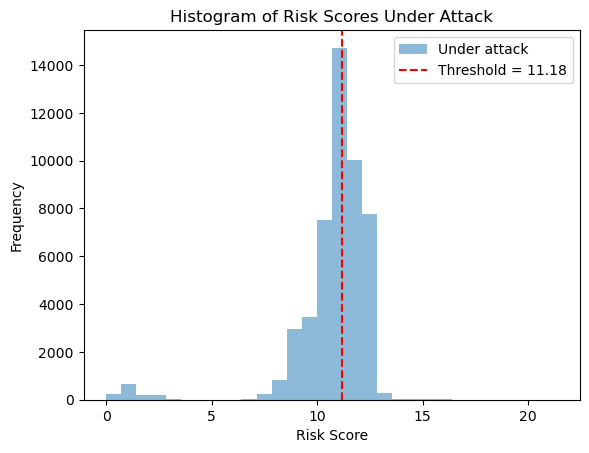

In [96]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(attack_df['risk_score'], bins=30, alpha=0.5, label='Under attack')

# Adding a vertical line at the threshold
plt.axvline(x=11.1775007344473, color='r', linestyle='--', label='Threshold = 11.18')

# Labels and titles
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.title('Histogram of Risk Scores Under Attack')

# Add a legend to make it clear what each component is
plt.legend()

# Show the plot
plt.show()
